In [1]:
import os
os.chdir("..")

In [2]:
from commons.api.utils import set_to_our_gpus, enable_web_access
set_to_our_gpus()
enable_web_access()

In [9]:
from juneja.validation_pipeline.preprocess import img_to_tensor
from commons.api.metric.compare_metrics import SIM, CC, NSS, AUC_Judd, wasserstein_distance
from commons.api.metric.compare_metrics import calculate_metrics
from api.metrics import apply_grey_patch, add_random_noise_to_image
# from juneja.validation_pipeline.inference import generate_saliency

from commons.api.imagenet_tiny import get_imagenet_classes, get_random_images


from shardul.api.viz import visualize_saliency_overlay
from commons.api.imagenet_tiny import get_imagenet_classes, get_random_images


In [10]:
import matplotlib
import matplotlib.gridspec as gridspec


from PIL import Image
from PIL import Image, ImageDraw
from scipy.signal import convolve2d
from numpy import random
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
import skimage.transform
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.spatial.distance import cdist
from pyemd import emd
import tensorflow as tf
from cv2 import EMD
from captum.attr import LayerAttribution, LayerGradCam
import cv2
# from ScoreCAM import cam

from PIL import Image
from matplotlib.pyplot import imshow
from torchvision import models, transforms
from torchvision.utils import save_image

In [11]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
model_gpu = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True).to(device)
# model_cpu = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
model_gpu.eval();
target_layer = model_gpu.layer4[1].conv2
classes = get_imagenet_classes()
resnet_transform = transforms.Compose([transforms.Resize((256, 256)),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

scorecam_wrapped_model = ScoreCAM(model_gpu, target_layer)
gradcam_wrapped_model = GradCAM(model_gpu, target_layer)

Using cache found in /home/shkulkar/.cache/torch/hub/pytorch_vision_v0.10.0


In [12]:
def gkern(l=5, sig=1.):
    # side length `l`
    # sigma `sig`
    ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
    gauss = np.exp(-0.5 * np.square(ax) / np.square(sig))
    kernel = np.outer(gauss, gauss)
    return kernel / np.sum(kernel)

def generate_focus_point(img, focus_points):
    img = Image.fromarray(img)
    draw = ImageDraw.Draw(img)
    for idx, fp in enumerate(focus_points):
        p, r, fill_value = fp
        left_up_point = (p[0]-r, p[1]-r)
        right_down_point = (p[0]+r, p[1]+r)
        two_point_list = [left_up_point, right_down_point]
        draw.ellipse(two_point_list, fill=fill_value)
    img_np = np.array(img)
    kernel = gkern(30, 7)
    img_np = convolve2d(img_np, kernel, mode="same")
    return img_np

In [29]:
def wasserstein_distance(cam, perturbed_cam):
    """
    Calculate the Earth Mover's Distance (EMD) between two saliency maps.

    Args:
        cam (numpy.ndarray): Reference saliency map.
        perturbed_cam (numpy.ndarray): Comparison saliency map.

    Returns:
        float: The Earth Mover's Distance (EMD) between the two saliency maps.

    Note:
    - The Earth Mover's Distance is a measure of the dissimilarity between two probability distributions.
    - A small constant is added to the saliency maps to avoid division by zero.
    - If the shapes of the two maps are different, the `perturbed_cam` is resized to match the shape of `cam`.
    - The EMD is computed after normalizing the maps to have values between [0, 1].

    References:
    - The Earth Mover's Distance (EMD) is used as a metric for comparing saliency maps.
    """
    # Add a small constant to avoid division by zero
    if cam.shape != perturbed_cam.shape:
        perturbed_cam = resize(perturbed_cam, cam.shape, order=3, mode='symmetric')

    cam += 1e-6
    perturbed_cam += 1e-6

    cam_max = cam.max()
    perturbed_max = perturbed_cam.max()

    # Normalize cam and perturbed_cam to have values between [0, 1]
    cam_normalized = cam / cam_max
    perturbed_normalized = perturbed_cam / perturbed_max
    
    cam_normalized = cam_normalized.astype(np.float32)
    perturbed_normalized = perturbed_normalized.astype(np.float32)

    emd = EMD(cam_normalized, perturbed_normalized, 2)
    return emd[0]

In [30]:
def plot_comparison_focus_points(focus_points, changes, name):
    fig , axes = plt.subplots(ncols=2, nrows=1)
    fig.set_figheight(12)
    fig.set_figwidth(12)

    sal_1 = generate_focus_point(blank_img, focus_points)
    axes[0].imshow(sal_1)
    axes[0].set_title("Reference")
    for idx, fp in enumerate(focus_points):
        xy, r, fill_value = fp
        x, y = xy
        axes[0].text(x-10, y+4, f'{idx}:{fill_value:.1f}', color="navy", fontsize=15)
        

    changed_focus_ps = []
    for idx, change in enumerate(changes):
        translate, scale, value = change
        fp = []
        pos = [focus_points[idx][0][0] + translate[0],  focus_points[idx][0][1] + translate[1]]
        fp.append(pos)
        fp.append(focus_points[idx][1] * scale)
        fp.append(focus_points[idx][2] * value)
        changed_focus_ps.append(fp)

    sal_2 = generate_focus_point(blank_img, changed_focus_ps)
    axes[1].imshow(sal_2)
    for idx, fp in enumerate(changed_focus_ps):
        xy, r, fill_value = fp
        x, y = xy
        axes[1].text(x-10, y+4, f'{idx}:{fill_value:.1f}', color="navy", fontsize=15)
    axes[1].set_title(f"Comparative. EMD = {wasserstein_distance(sal_1, sal_2):.4f}");
    for ax in axes:
        ax.axis('off')
    fig.suptitle("EMD", fontsize=16, fontweight="bold", y=0.7, x = 0.51)
    fig.savefig(f"/project/validating_attribution_techniques/shardul/data/Doc/Background/Metrics/EMD/{name}.png")

In [31]:
blank_img = np.zeros((224, 224))
focus_points = [[[140, 140], 20, 1.0], # 0
                [[130, 80], 15, 0.4], # 1
                [[100, 160], 10, 0.8], # 2
                [[160, 100], 16, 0.4], # 3
                [[75, 90], 15, 0.7]]  # 4

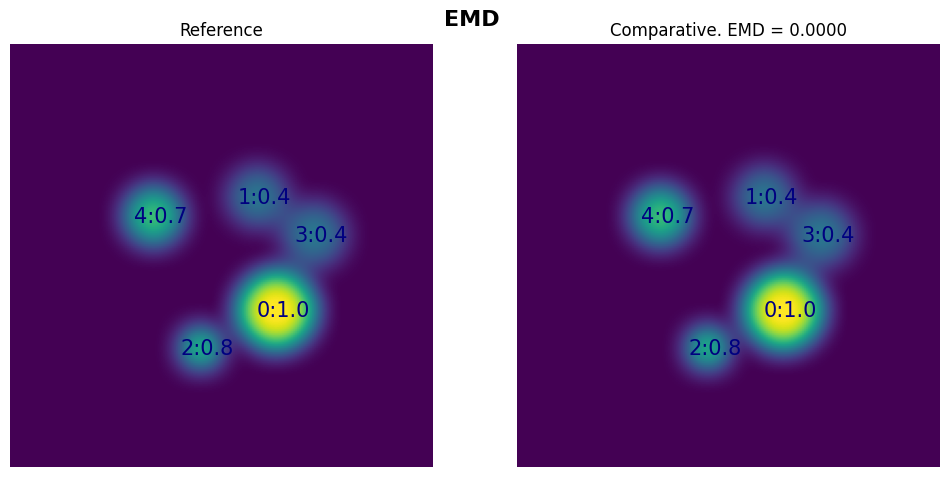

In [33]:
# Positive case where the both the saliencies are same in location and intensity
plot_comparison_focus_points(focus_points, [[(0, 0), 1, 1], # 0
                                                [(0, 0), 1, 1], # 1
                                                [(0, 0), 1, 1], # 2
                                                [(0, 0), 1, 1], # 3
                                                [(0, 0), 1, 1]], 'Saliency_original') # 4

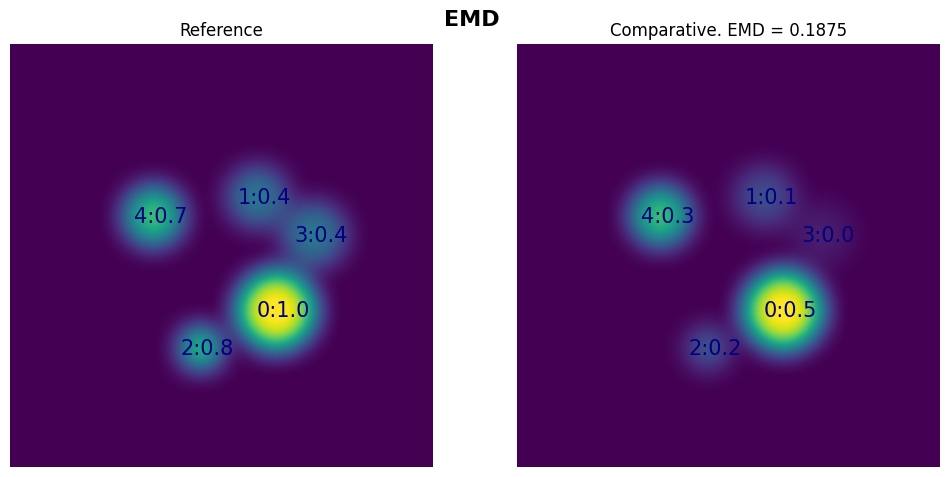

In [34]:
#Location of point is changed
plot_comparison_focus_points(focus_points, [[(0, 0), 1, 0.5], # 0
                                                [(0, 0), 1, 0.3], # 1
                                                [(0, 0), 1, 0.2], # 2
                                                [(0, 0), 1, 0.1], # 3
                                                [(0, 0), 1, 0.5]], name = 'Saliency_intensity_change') # 4

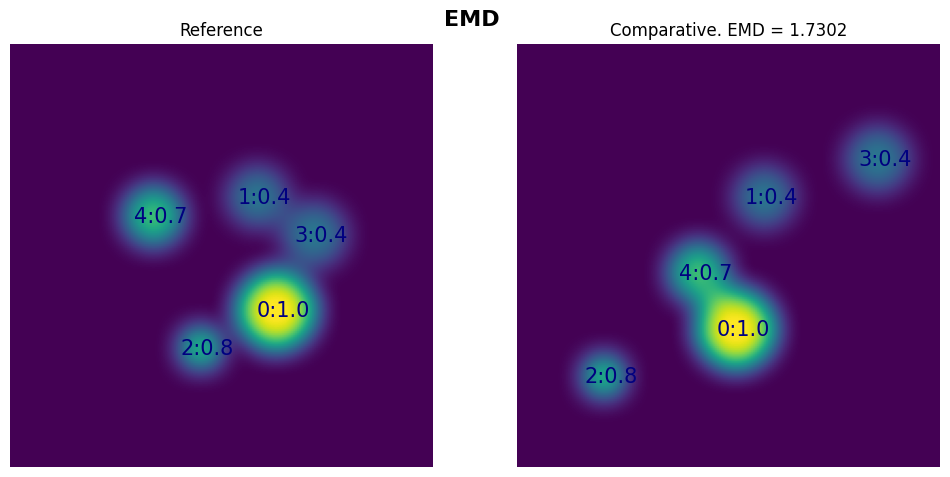

In [40]:
#Location of point is changed
plot_comparison_focus_points(focus_points, [[(-25, 10), 1, 1], # 0
                                                [(0, 0), 1, 1], # 1
                                                [(-55, 15), 1, 1], # 2
                                                [(30, -40), 1, 1], # 3
                                                [(20, 30), 1, 1]], name = 'Saliency_location_change') # 4

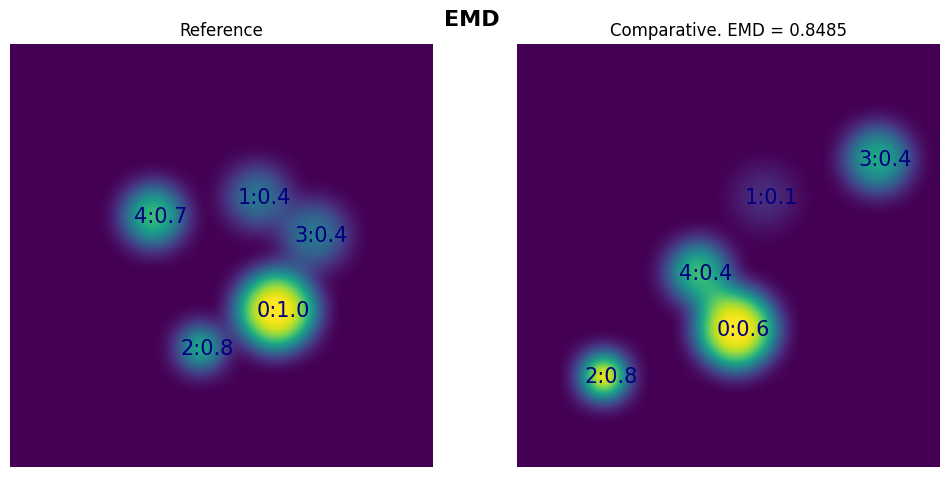

In [38]:
#Location of point is changed
plot_comparison_focus_points(focus_points, [[(-25, 10), 1, 0.6], # 0
                                                [(0, 0), 1, 0.2], # 1
                                                [(-55, 15), 1, 1], # 2
                                                [(30, -40), 1, 0.9], # 3
                                                [(20, 30), 1, 0.6]], name = 'Saliency_location_intensity_change') # 4

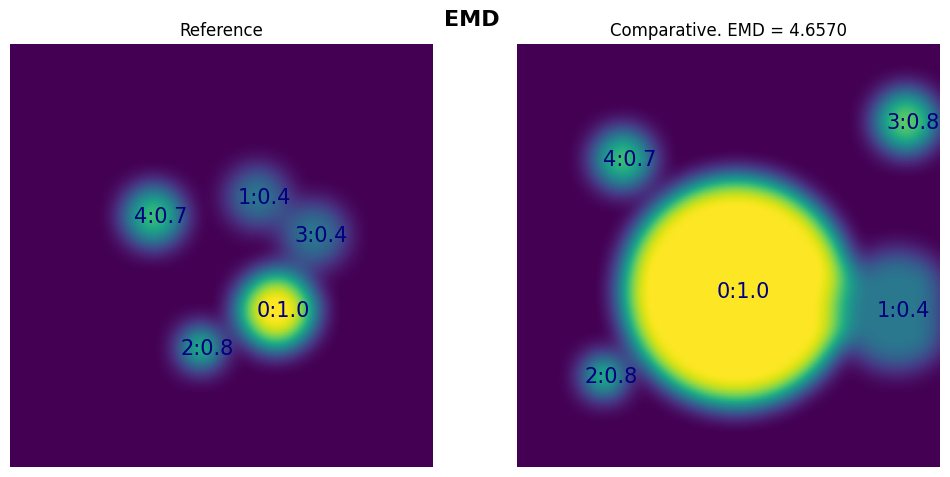

In [50]:
#Location of point is changed
plot_comparison_focus_points(focus_points, [[(-25, -10), 3, 1], # 0
                                                [(70, 60), 2, 1], # 1
                                                [(-55, 15), 1, 1], # 2
                                                [(45, -60), 1, 1.9], # 3
                                                [(-20, -30), 1, 1]], name = 'Saliency_location_change_2') # 4